# Ca channels: inactivation

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ca channel recordings in the "data/Ca_channels" folder

In [2]:
data_folder = "data/3-Ca_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/3-Ca_channels


['data/3-Ca_channels/CAV_Tho_IV.abf', 'data/3-Ca_channels/2024_06_10_0027.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
data_file = 'data/3-Ca_channels/CAV_Tho_IV.abf'

Now we can load the file and plot the raw data:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

Trace('CAV_Tho_IV.abf')
Number of sweeps: 32
Points per sweep: 13,750
Duration per sweep: 0.275 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage, TTL


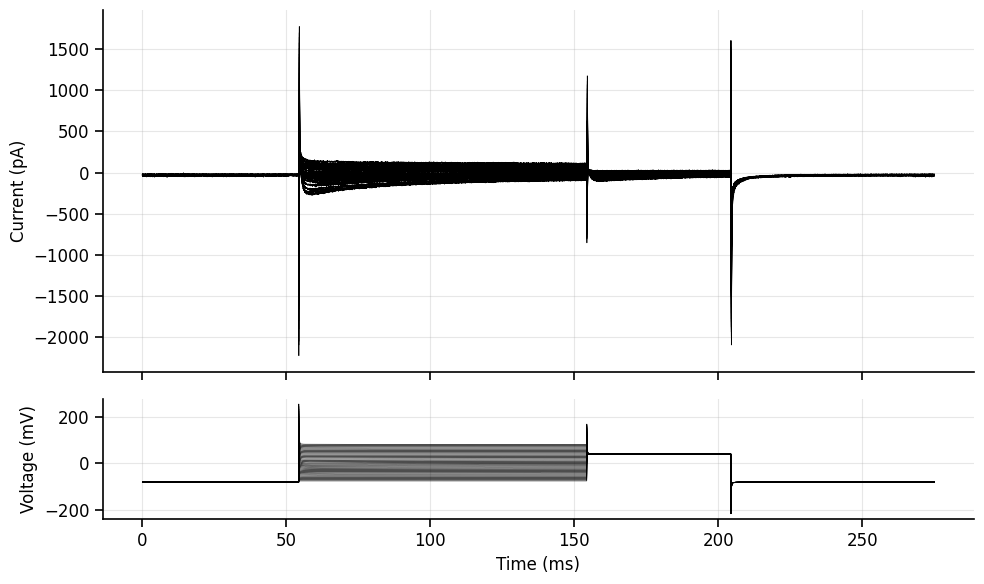

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
traces.plot(plot_voltage=True, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### 2.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True
start_baseline = 0
end_baseline = 0.1

In [ ]:
if subtract_baseline:
    traces.subtract_baseline(start_time = start_baseline, 
                             end_time = end_baseline , 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'current')  # Options: 'current', 'voltage', 'all'
    %matplotlib widget
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### 2.2. Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
additional_filtering = False

In [ ]:
if additional_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends.
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
    filtered_traces = filtered_traces.filter(
        line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width=0.5,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        highpass=0.5,   # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
        lowpass=4900,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
        order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.

    %matplotlib widget
    ax = filtered_traces.plot(plot_voltage=False, plot_ttl=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()

Once you are happy with the filter setting, run the next cell to implement them:

In [ ]:
if additional_filtering:
    traces=filtered_traces

## 3. Select what you want to measure

### 3.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

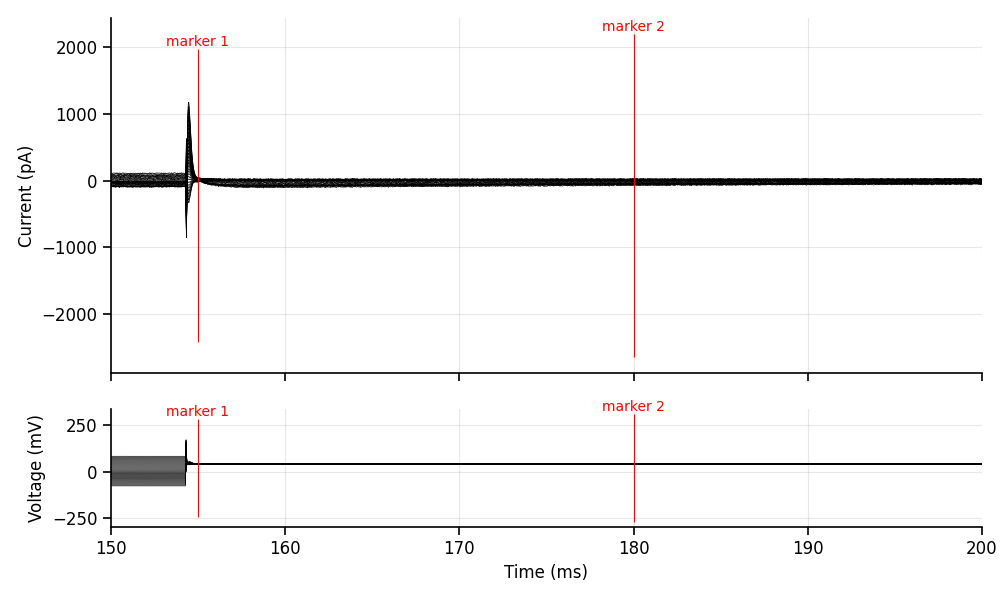

In [5]:
# The start/end time just helps to zoom in on the traces.
start_time = 150
end_time = 200

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 155
marker_2 = 180
time_units = 'ms'

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(start_time,end_time)
ax2.set_xlim(start_time,end_time)
plt.show()

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

First we want to measure the holding voltages from the first phase of the step protocol:


In [6]:
# Define the timepoint where the voltage is measured
voltage_timepoint = 150

# ------------------------------------------------------------------------------------------------
_,voltage_steps = traces.get_measurements(start_time=voltage_timepoint, end_time=voltage_timepoint+1, time_units=time_units, sweep='all')

Now we can actually measure the currents and normalized againts the max current.

Text(0, 0.5, 'Current')

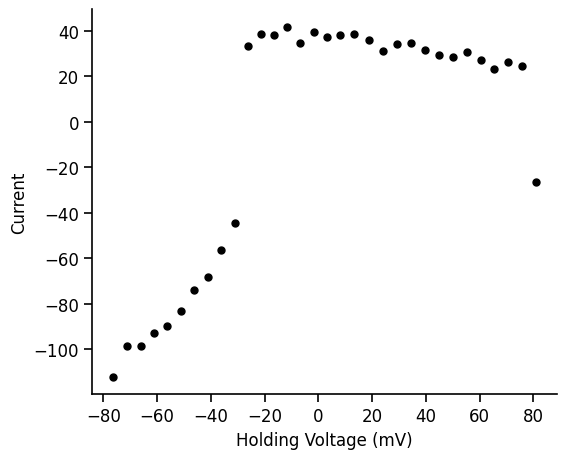

In [8]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

current_steps,_ = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                        measurement_type=measurement_type, time_units=time_units)

# Plot the normalized current steps against the holding voltages
%matplotlib inline
fig,ax = plt.subplots(figsize=(6, 5))
ax.plot(voltage_steps, current_steps, 'o', color='black', markersize=5)
ax.set_xlabel('Holding Voltage (mV)')
ax.set_ylabel('Current')

Boltzmann Fit parameters:
V_half: -35.236, k: -7.655


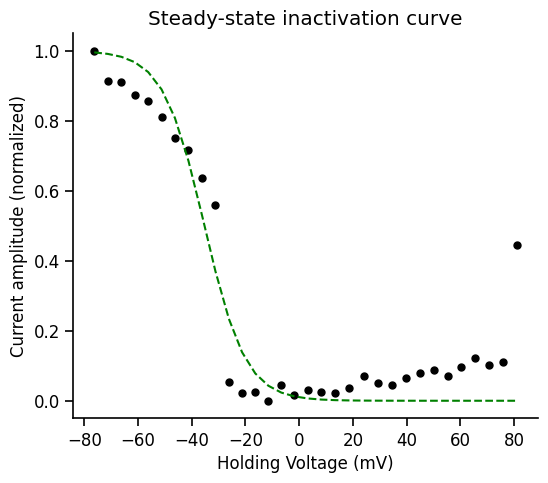

In [11]:
# Min-max normalize
current_steps = (current_steps - np.min(current_steps)) / (np.max(current_steps) - np.min(current_steps))

# Plot the normalized current steps against the holding voltages
%matplotlib inline
fig,ax = plt.subplots(figsize=(6, 5))
ax.plot(voltage_steps, current_steps, 'o', color='black', markersize=5)
ax.set_xlabel('Holding Voltage (mV)')
ax.set_ylabel('Current amplitude (normalized)')
ax.set_title('Steady-state inactivation curve')

# Optional: fit a Boltzmann function (sigmoid curve) to the data
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = -5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, current_steps, p0=[np.median(voltage_steps), k_guess])
ax.plot(voltage_steps, boltzmann(voltage_steps, *popt), linestyle='--', color='g', label='Fit')
print("Boltzmann Fit parameters:")
print(f"V_half: {popt[0]:.3f}, k: {popt[1]:.3f}")
plt.show()